<center><h1> Week 2: Multilayer Perceptrons and Stochastic Gradient Descent Solutions </h1></center>
<center> Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>
    <center>  </center>

This notebook is inspired by the [D2L book](https://d2l.ai/) and adapted from lecture material created by Krishna Pillutla.

In [33]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time
import copy

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

## Part 0: PyTorch Preliminaries
PyTorch's automatic differentiation works by building a 
"computation graph" of all operations on tensors with `requires_grad=True`. 
It then computes the requested gradients by performing 
reverse-mode automatic differentiation, a.k.a. backpropagation. 

![Computational graph](https://upload.wikimedia.org/wikipedia/commons/a/a0/ReverseaccumulationAD.png)

There are number of caveats to keep in mind:

- Automatic differentiation only works for floating point types (float32, float64). It does not work for integer types. (Think about why this is the case).
- "Building a computation graph" takes up space. The memory usage increases proportional to the number of intermediate quantities stored.

There are number of operations one might want to perform without building a computational graph. Examples include:

- SGD updates
- Accuracy computation (in general, logging utilies)

PyTorch allows you to "hide" computations from autograd using
`torch.no_grad()` (for example, see the accuracy computation functions below).

## Part 0.1: Automatic Differentiation Practice 

Use PyTorch's automatic differentiation routines to compute the following derivatives/gradients and verify them on sample inputs. The solution to the first one is provided as an example.

1. $f : \mathbb{R}^3 \to \mathbb{R}$ defined by $f(x) = \|x\| = \sqrt{x_1^2 + x_2^2 + x_3^2}$. Find $\nabla_x f(x)$ for some $x\neq 0$ (note that $f$ is not differentiable at $0$).
1. $g: \mathbb{R}^3 \to \mathbb{R}$ defined by $g(y) = \frac{\exp(y_1)}{\exp(y_1) + \exp(y_2) + \exp(y_3)}$. Find $\nabla_y g(y)$.
1. $h: \mathbb{R}^2 \times \mathbb{R}^3 \to \mathbb{R}$ with $h(a, b) = a^\top M b$ and $M\in \mathbb{R}^{m \times n}$ is the matrix of all ones (i.e., $M_{ij}=1$ for each $i, j$). Find $\nabla_a h(a, b)$ and $\nabla_b h(a, b)$.

In [17]:
## Solution to Part 1 in two ways:
x = torch.randn(3, requires_grad=True)
true_gradient = x / torch.norm(x)  # computed analytically for verification

# (a) Using the `.backward()` call
output = torch.norm(x)
output.backward()
gradient = x.grad 
print(x, gradient, true_gradient)

# (b) Using the `torch.autograd.grad` call
output = torch.norm(x)
# `torch.autograd.grad` returns a list. It has only one entry in this example
gradient = torch.autograd.grad(outputs=output, inputs=[x])[0]
print('1', x, gradient, true_gradient)

## Solution to Part 2
# <Your code here>
y = torch.randn(3, requires_grad=True)
output = torch.exp(y[0]) / torch.exp(y).sum()
gradient = torch.autograd.grad(outputs=output, inputs=[y])[0]
print('2', y, gradient)


## Solution to Part 3
a = torch.randn(2, requires_grad=True)
b = torch.randn(3, requires_grad=True)
M = torch.ones(2, 3, requires_grad=False)  # do not need gradient w.r.t. M
output = torch.dot(a, torch.matmul(M, b))
gradients = torch.autograd.grad(outputs=output, inputs=[a, b])
print('3', (a, b), gradients)

tensor([ 1.5410, -0.2934, -2.1788], requires_grad=True) tensor([ 0.5740, -0.1093, -0.8115]) tensor([ 0.5740, -0.1093, -0.8115], grad_fn=<DivBackward0>)
1 tensor([ 1.5410, -0.2934, -2.1788], requires_grad=True) tensor([ 0.5740, -0.1093, -0.8115]) tensor([ 0.5740, -0.1093, -0.8115], grad_fn=<DivBackward0>)
2 tensor([ 0.5684, -1.0845, -1.3986], requires_grad=True) tensor([ 0.1869, -0.1080, -0.0789])
3 (tensor([0.4033, 0.8380], requires_grad=True), tensor([-0.7193, -0.4033, -0.5966], requires_grad=True)) (tensor([-1.7192, -1.7192]), tensor([1.2414, 1.2414, 1.2414]))


Let us now generalize these examples to high dimensions.

1. $f : \mathbb{R}^n \to \mathbb{R}$ defined by $f(x) = \|x\| = \sqrt{\sum_{j=1}^n x_j^2}$. Find $\nabla_x f(x)$ for some $x\neq 0$ (note that $f$ is not differentiable at $0$).
1. $g: \mathbb{R}^3 \to \mathbb{R}$ defined by $g(y) = \exp(y_1)/\sum_{k=1}^n \exp(y_k)$. Find $\nabla_y g(y)$.
1. $h: \mathbb{R}^m \times \mathbb{R}^n \to \mathbb{R}$ with $h(a, b) = a^\top M b$ and $M\in \mathbb{R}^{m \times n}$ is the matrix of all ones (i.e., $M_{ij}=1$ for each $i\in[m],j\in[n]$). Find $\nabla_a h(a, b)$ and $\nabla_b h(a, b)$.

For these examples, you may take $n = 100$ and $m = 50$.

In [18]:
# same as above

## Part 1: SGD for logistic regression versus the learning rate

We will run SGD on the same fashion MNIST dataset as in the demo. Our goal here is to study the effect of the learning rate on the train/test loss/accuracy.

Your task is to fill in the SGD update (look for `# <Your code here>`) and make the requested plots.

In [34]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('../data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]


print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


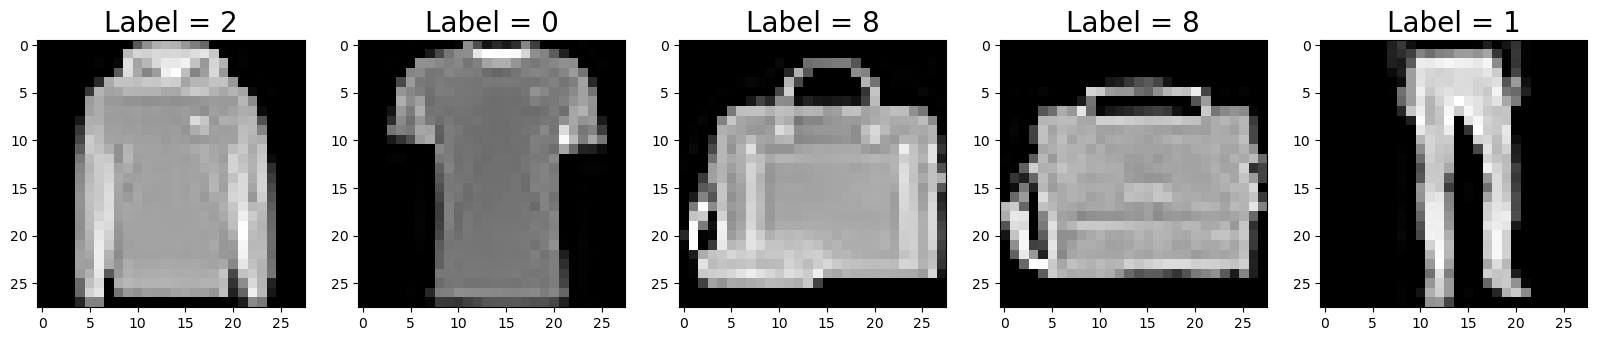

In [20]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)

In [35]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [36]:
# Some utility functions to compute the objective and the accuracy
def compute_objective(w, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        Require w of shape (d,), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * torch.norm(w)**2
    )

@torch.no_grad()
def compute_accuracy(w, X, y):
    """ Compute the classification accuracy
        Require w of shape (d,), X of shape (n, d) and y of shape (n,)
    """
    score = torch.matmul(X, w)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    # <Your code here>: compute the accuracy from predictions and y
    # Return the fraction of predictions that are correct
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(w, reg_param, verbose=False):
    train_loss = compute_objective(w, X_train, y_train, reg_param)
    test_loss = compute_objective(w, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(w, X_train, y_train)
    test_accuracy = compute_accuracy(w, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [37]:
def sgd_one_pass(w, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1    
        objective = compute_objective(w, X[idx:idx+1], y[idx:idx+1], reg_param) 
        
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradient = torch.autograd.grad(outputs=objective, inputs=w)[0]
        
        # perform SGD update
        with torch.no_grad():
            # <Your code here>
            w -= learning_rate * gradient
    return w

Find the divergent learning rate. Edit the code below to change the learning rate. 

*Hint 1*: Try different orders of magnitude. For instance, start with 1e-2. If it diverges, try 1e-6, if not, try 10.0. Once we establish a lower and upper bound on it, finding the divergent learning rate comes down to a binary search (on a logarithmic scale). 

*Hint 2*: A common strategy is to search in powers of 10 (as in hint 1), and then narrow the search down in powers of 2. For instance, if we end up with 1e-3 as an estimate of the divergent learning from hint 1, try out 2e-3 and 4e-3 as well in order to refine the estimate of the divergent learning rate. 

**Note**: the divergent learning rate is a heuristic which gives the right ballpark figure of the learning rate. 
A learning rate that satisfies the heuristic might still result in the loss diverging, in which case we would have redo the process with half that learning rate.

In [40]:
learning_rate = 
reg_param = 0.0

w = torch.zeros(784, n_class, requires_grad=True)
_ = compute_logs(w, reg_param, verbose=True)


w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(w, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.100
46.309841199832455
61.18803277114455
73.914209288071
87.03468480063317
92.41075005714353
72.18908974032949
67.66999374759132
74.06777361520288
79.3103142463911
79.93967188784309
81.06656483030568
85.16267920623591
64.27852133783651
66.6947606014821
83.87482556618248
60.81811818475449
51.767233071879524
62.82075807824437
124.7095230348096
64.53318354844029
84.77653742184796
78.53682461613408
58.68884585856807
61.28374479346992
48.419114468182556
46.445329456139206
64.33274603608868
56.58390267374371
73.8079494547917
50.64519327724269
63.29431596900384
44.5048459778461
52.82167467404944
45.768557376385864
51.864565669826796
56.239686578172055
58.83935224797221
52.86967831955849
46.6117829175481
53.64242769523698
54.87829885621678
53.13803180710188
49.691137813711734
56.270647716142946
45.738799778953805
58.19148509778167
79.06815829721786
62.24054876573236
41.607353441675095
48.831677567463586
44.0721982

Now complete the following function which runs SGD for 20 passes through the data and tracks the test accuracy at the end of each pass. 

In [25]:
# Note: X_train, y_train, X_test, y_test are global variables
def run_sgd(w, reg_param, learning_rate, num_passes=20, verbose=True):
    logs = []

    logs.append(compute_logs(w, reg_param, verbose=verbose))
#     logs.append(# <Your code here>)
    for j in range(num_passes):
        w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=False)
        logs.append(compute_logs(w, reg_param, verbose=verbose))
#     for j in range(num_passes):
#         # <Your code here>. Hint: call sgd_one_pass
        # w = sgd_one_pass(w, X_train, y_train, reg_param, learning_rate, verbose=False)
#         logs.append(# <Your code here>)
    return w, logs

Run SGD for the learning rates from the list `[1e-2, 1e-3, 1e-4, 1e-5]` for 10 epochs. 
Plot 4 curves:

 - Train loss vs number of passes,
 - Train accuracy vs number of passes,
 - Test loss vs number of passes,
 - Test accuracy vs number of passes.
 
 Each curve must contain multiple lines, each corresponding to a different learning rate. 
 You may use `reg_param=1e-3`.

In [26]:
w = torch.zeros(784, n_class, requires_grad=True)
reg_param = 1e-3

learning_rate_list = [1e-2, 1e-3, 1e-4, 1e-5]
logs_list = [np.asarray(run_sgd(
    copy.deepcopy(w), reg_param, lr, num_passes=10, verbose=False)[1])
           for lr in learning_rate_list]

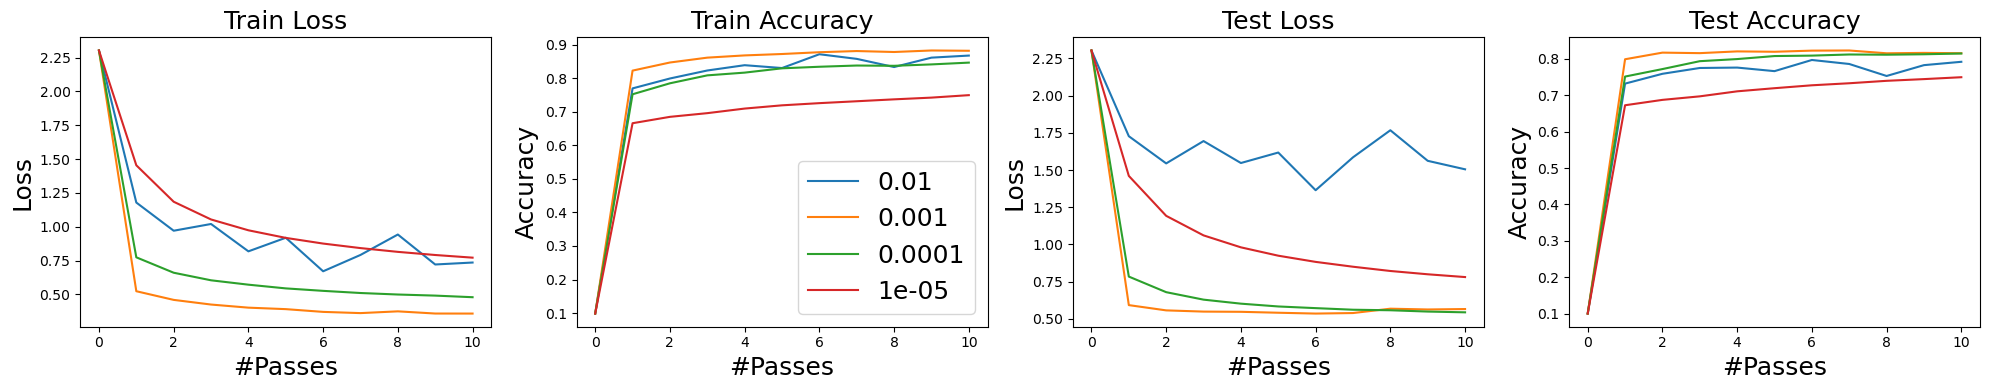

In [27]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Train Accuracy', fontsize=18)
ax[2].set_title('Test Loss', fontsize=18)
ax[3].set_title('Test Accuracy', fontsize=18)
for i in range(4):
    ax[i].set_xlabel('#Passes', fontsize=18)
    ax[i].set_ylabel('Loss' if i%2==0 else 'Accuracy', fontsize=18)
    for log, lr in zip(logs_list, learning_rate_list):
        ax[i].plot(log[:, i], label=lr)
        
ax[1].legend(fontsize=18)
plt.tight_layout()

## Part 2: The effect of learning rate and initialization on MLPs
We will repeat the same experiment with MLPs.

Start by filling in the blank in the `sgd_one_pass` function.

In [28]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective_mlp(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs) # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy_mlp(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs_mlp(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective_mlp(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective_mlp(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy_mlp(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy_mlp(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def sgd_one_pass_mlp(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    # Each pass through the data is called an `epoch`.
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective_mlp(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(all_parameters, gradients):
                w -= learning_rate * g
    return ws, bs

Find the divergent learning rate. Edit the code below to change the learning rate. 


In [29]:
learning_rate = 1e-2

hidden_size = 1024
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs_mlp(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs_mlp(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.107, Test Loss = 2.303, Test Accuracy = 0.104
1.4608688067301945
1.9935385814615096
2.190205213766035
2.2625879482958493
2.218406155068027
2.113592128431685
1.884566092907903
1.6666786056740566
1.47971022156947
1.292205838647769
1.1330332113995678
1.098358722515573
0.8810172361305078
0.7799120048379085
0.7468019906390517
0.8002730866901167
0.8959964224301074
0.7258446502738465
0.7330806191485391
0.7561592533662446
0.7422933515920207
0.7222148757634024
0.7798218237458621
0.836157047621625
0.809795745328696
0.7619052663009322
0.7045439912090746
0.7845469141240561
0.5331132569383918
0.660595932426854
0.593440507372235
0.5900601147848366
0.5090652081310999
0.6543430703122688
0.6284501518866441
0.635833794764802
0.7668142182560959
0.7181354832981939
0.6519859386879842
0.6556035343513108
0.5070594585545165
0.5127484977241192
0.750392527876408
0.6275826054073905
0.6191557676752807
0.5605199144411612
0.5388367937414991
0.6494391956304386
0.660943684031261

Next, we write a function which makes a certain number of passes of SGD.

In [30]:
def run_sgd_mlp(ws, bs, reg_param, learning_rate, num_passes=10, verbose=True):
    logs = [compute_logs_mlp(ws, bs, reg_param, verbose=verbose)]
    # We run training for multiple epochs. Each epoch is a pass through the data.
    for j in range(num_passes):
        ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, 
                          reg_param, learning_rate, verbose=False)
        logs.append(compute_logs_mlp(ws, bs, reg_param, verbose=verbose))
    return ws, bs, np.asarray(logs)

Run SGD for the learning rates from the list `[1e-2, 1e-3, 1e-4, 1e-5]` for 10 epochs. 
Plot 4 curves:

 - Train loss vs number of passes,
 - Train accuracy vs number of passes,
 - Test loss vs number of passes,
 - Test accuracy vs number of passes.
 
 Each curve must contain multiple lines, each corresponding to a different learning rate. 
 You may use `reg_param=0`. 
 
 Note: This takes several minutes to run. On my laptop, it took 10 min.

In [31]:
hidden_size = 512

def intialize_ws():
    ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
          1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
    return ws

def initialize_bs():
    bs = [torch.zeros(hidden_size, requires_grad=True),
          torch.zeros(n_class, requires_grad=True)]
    return bs

reg_param = 0

t1 = time.time()
learning_rate_list = [1e-2, 1e-3, 1e-4, 1e-5]
logs_list = [run_sgd_mlp(
    intialize_ws(), initialize_bs(), reg_param, lr, num_passes=10, verbose=False)[2]
           for lr in learning_rate_list]
t2 = time.time()
print('time:', round(t2-t1, 2))

time: 297.25


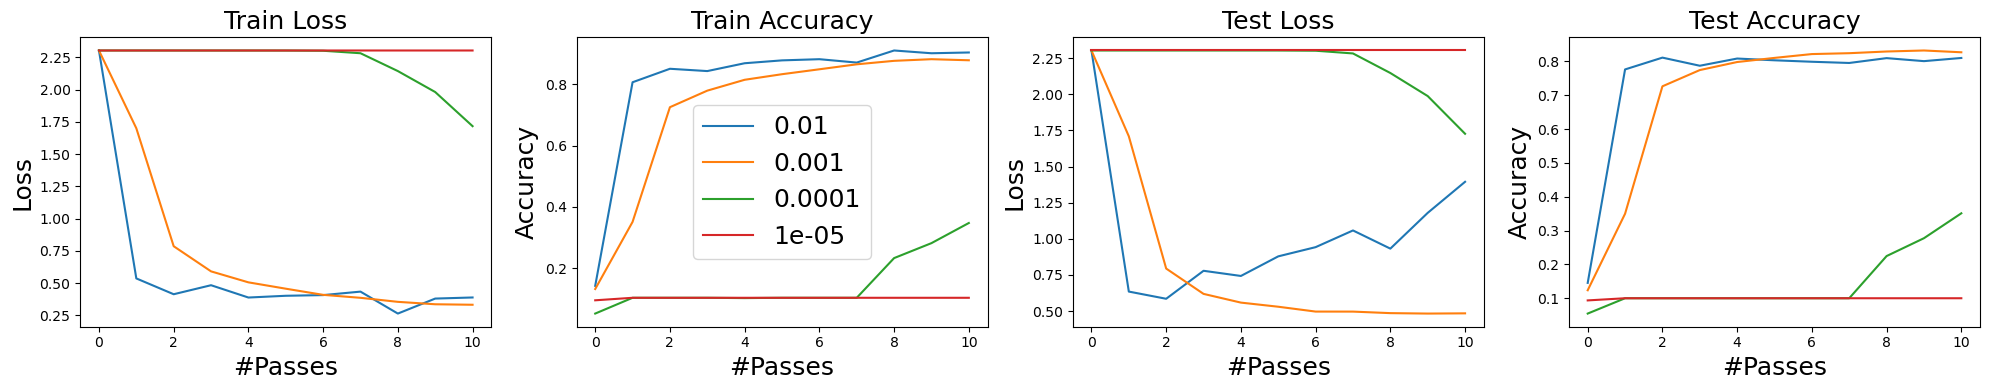

In [32]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Train Accuracy', fontsize=18)
ax[2].set_title('Test Loss', fontsize=18)
ax[3].set_title('Test Accuracy', fontsize=18)
for i in range(4):
    ax[i].set_xlabel('#Passes', fontsize=18)
    ax[i].set_ylabel('Loss' if i%2==0 else 'Accuracy', fontsize=18)
    for log, lr in zip(logs_list, learning_rate_list):
        ax[i].plot(log[:, i], label=lr)
        
ax[1].legend(fontsize=18)
plt.tight_layout()